In [38]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import pyaldata as pyd
import scipy
from utils import *
import ipywidgets as widgets
from IPython.display import display

# Load data

In [39]:
dataset = 'M027_2024_03_20_11_30'
mouse_id = 'M027'
probe_id = '0'


In [43]:
data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'+dataset+'_ephys/'+dataset+'_g0/'+dataset+'_g0_imec'+probe_id+'/sorter_output/'
sys.path.append(data_dir)
#import params

In [44]:
ops = np.load(data_dir+'ops.npy', allow_pickle=True).item()
camps = pd.read_csv(data_dir+'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
contam_pct = pd.read_csv(data_dir+'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
chan_map =  np.load(data_dir+'channel_map.npy')
templates =  np.load(data_dir+'templates.npy')
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
labels = pd.read_csv(data_dir+'cluster_KSLabel.tsv', sep='\t') # label for each cluster (can be good, or multiunit activity --mua)
amplitudes = np.load(data_dir+'amplitudes.npy')
st = np.load(data_dir+'spike_times.npy')# time when spike happened. to transform into seconds 
clu = np.load(data_dir+'spike_clusters.npy') # cluster identity of each spike
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
sys.path.append(data_dir)

#sample_rate = params.sample_rate
dshift = ops['dshift']


# Pre process spiking data

In [45]:
labels.head()

,cluster_id,KSLabel
0,0,mua
1,1,mua
2,2,good
3,3,mua
4,4,good


In [46]:
# Add firing rate to each cluster
labels['firing_rate'] = firing_rates
labels['chan'] = chan_best

In [47]:
# Add spike times for each cluster

# Create a DataFrame for spikes
spikes_df = pd.DataFrame({'spike_time': st, 'cluster_id': clu})

# Group by cluster and aggregate the spike times into lists
spike_times = spikes_df.groupby('cluster_id')['spike_time'].apply(list).reset_index()

# Merge this with the labels dataframe
labels = labels.merge(spike_times, on='cluster_id', how='left')

# If the clusters in 'labels' might have no corresponding spike times, ensure NaNs are replaced with empty lists
labels['spike_time'] = labels['spike_time'].apply(lambda x: x if isinstance(x, list) else [])


In [48]:
#good_units = labels[labels['KSLabel']=='good']
good_units = labels

In [49]:
good_units_sorted = good_units.sort_values(by='firing_rate', ascending=False).reset_index(drop=True)

In [50]:
good_units_sorted.head()

,cluster_id,KSLabel,firing_rate,chan,spike_time
0,680,good,28.537490,365,"[2009, 2355, 2771, 3156, 3509, 3688, 4129, 492..."
1,628,mua,28.172875,324,"[196, 565, 2998, 3268, 4624, 5117, 5698, 6765,..."
2,620,mua,25.833886,317,"[537, 1295, 2612, 2808, 2914, 3773, 4009, 4243..."
3,97,mua,23.593284,43,"[482, 978, 1366, 2527, 4174, 4511, 5334, 5478,..."
4,611,mua,22.340697,310,"[818, 1442, 1993, 5824, 8431, 11892, 14204, 14..."


# Get event data

In [51]:
data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'
fname = os.path.join(data_dir, dataset+'_pyaldata.mat')

df = pyd.mat2dataframe(fname, shift_idx_fields=False, td_name='df')


/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


field sol_nb could not be converted to int.


In [52]:
df['perturb_sec'] = df['event_time']/1000

In [53]:
df_perturbed = df[df['trialType']=='perturbation']

In [54]:
event_list = df_perturbed['event_time']

In [55]:
event_list

1       303008.0
2       306530.0
3       312221.0
4       322143.0
5       330861.0
         ...    
238    2063988.0
239    2069281.0
240    2079734.0
241    2091311.0
242    2095383.0
Name: event_time, Length: 242, dtype: float64

In [56]:
# Rasters

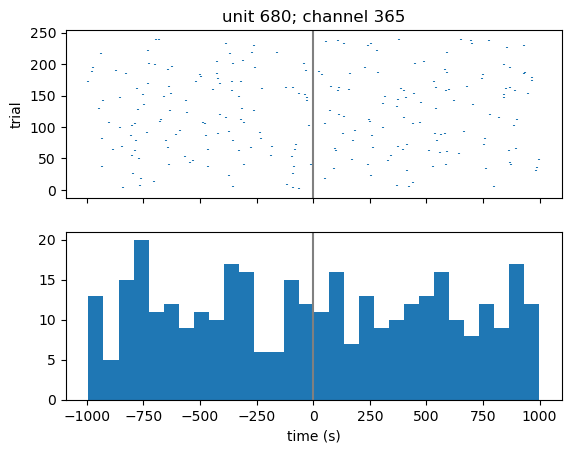

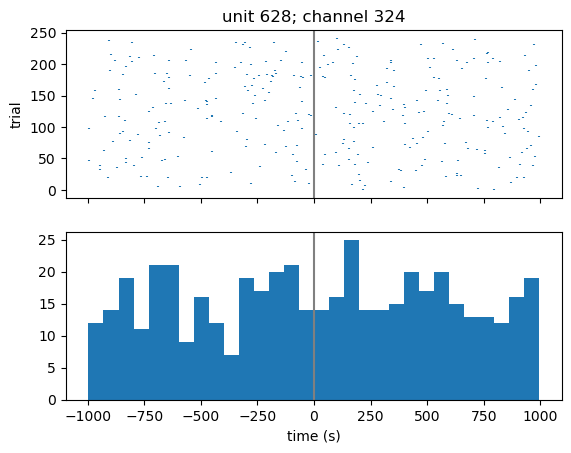

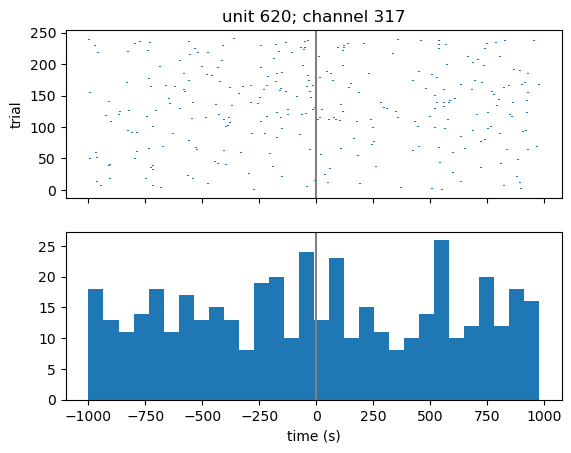

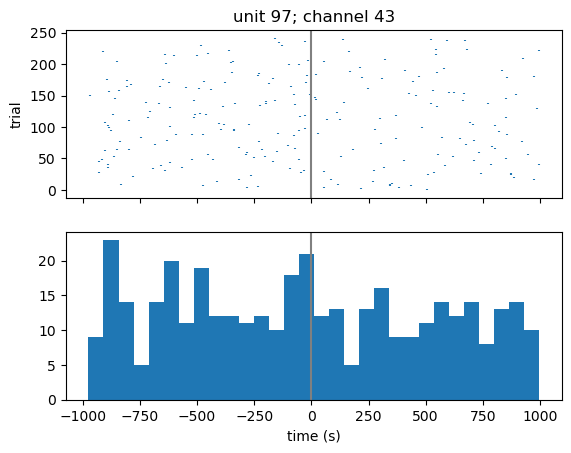

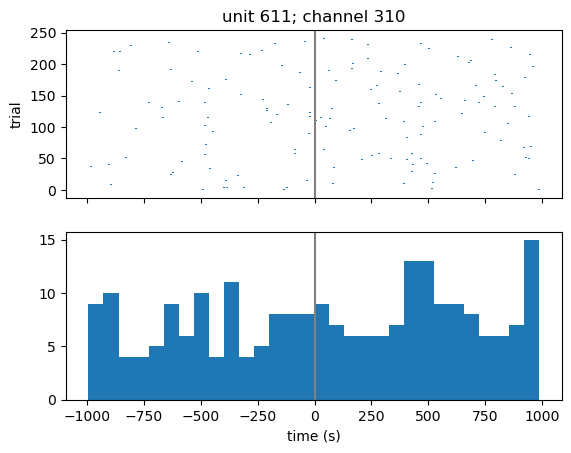

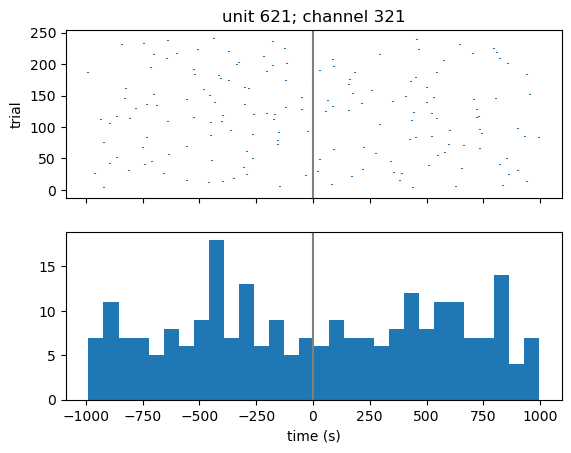

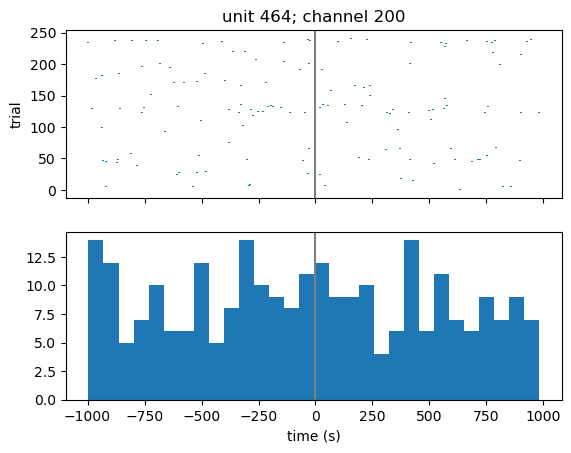

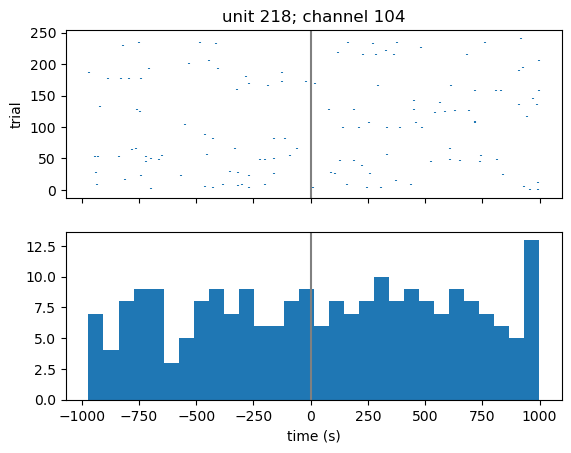

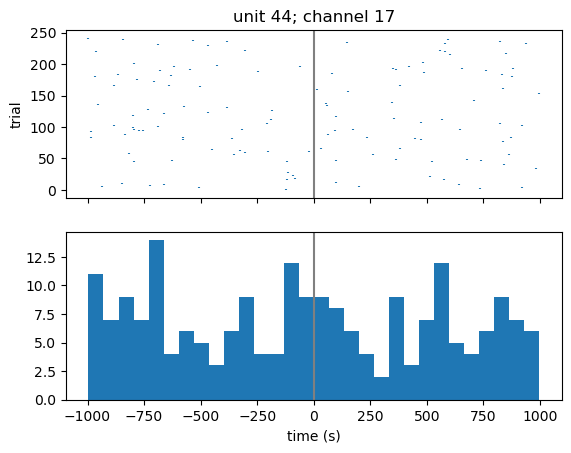

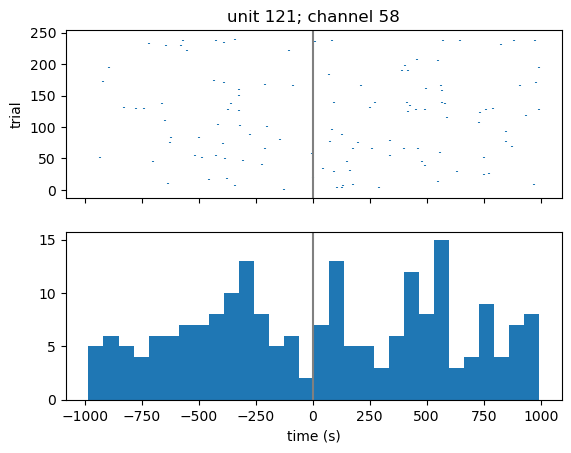

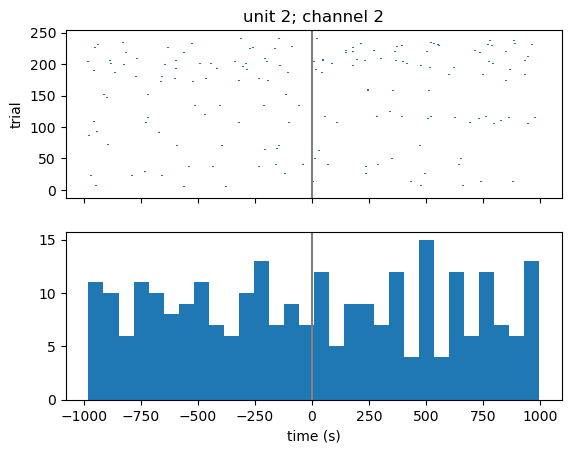

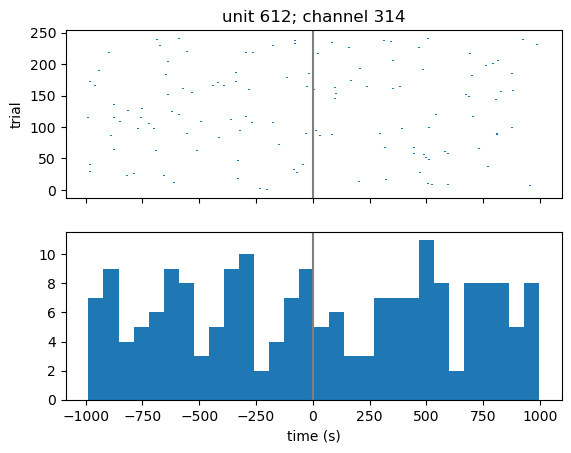

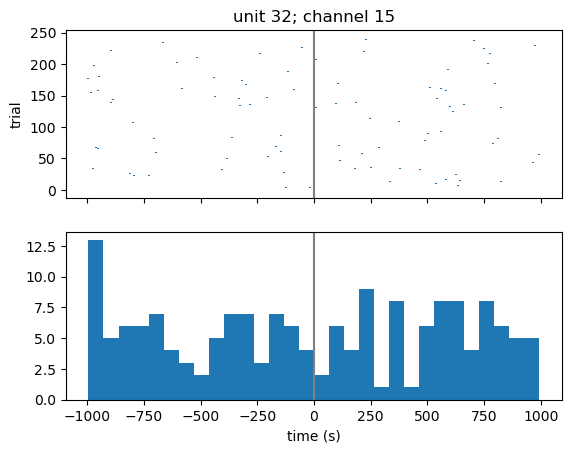

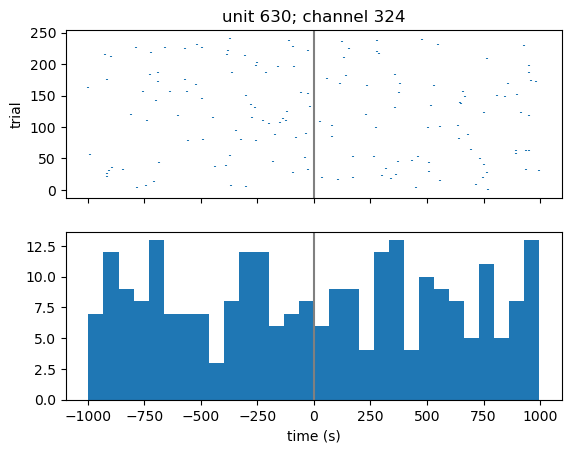

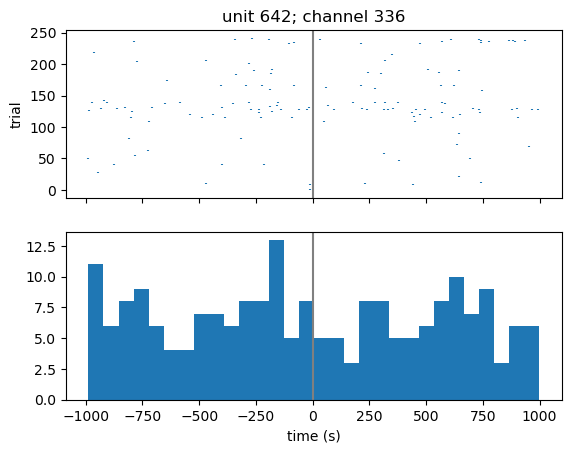

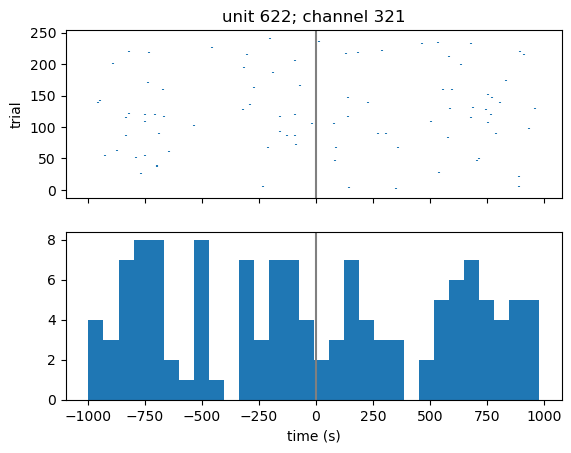

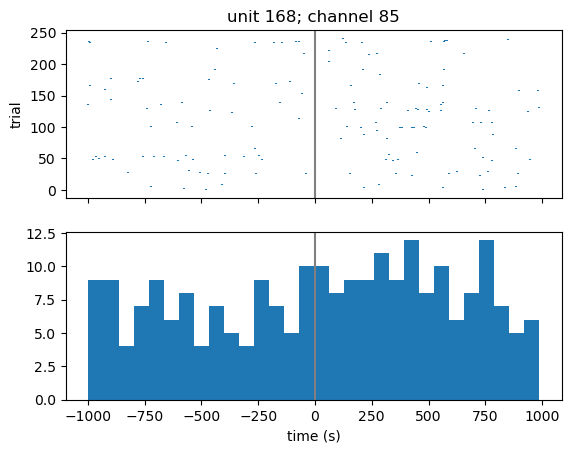

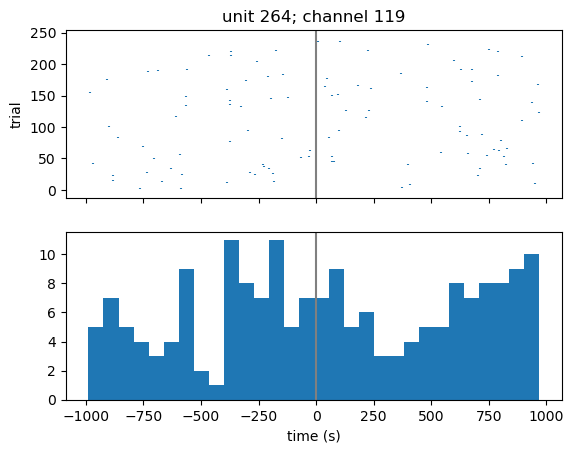

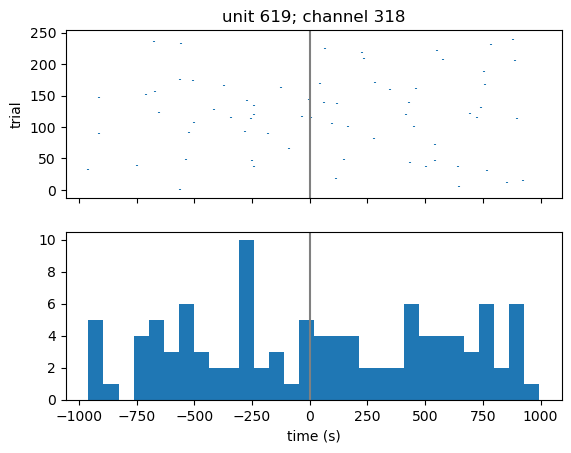

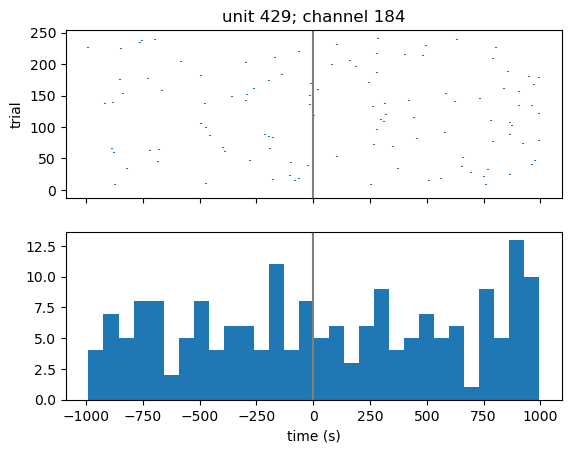

In [57]:
before = 1000 # in seconds 
after = 1000
# Get the stimulus times for all stimuli
# get_timestamps() works whether the time is stored as an array of timestamps or as # starting time and sampling rate.
stim_on_times = event_list.values

#for unit in good_units_sorted.index[2]:

for i in good_units_sorted.index[:20]:
    unit = good_units_sorted['cluster_id'][i]
    unit_spike_times = good_units_sorted["spike_time"][i] 
    trial_spikes = []
    for time in stim_on_times:
                # Compute spike times relative to stimulus onset
        aligned_spikes = unit_spike_times - time
        # Keep only spike times in a given time window around the stimulus onset 
        aligned_spikes = aligned_spikes[
            (-before < aligned_spikes) & (aligned_spikes < after)
        ]
        trial_spikes.append(aligned_spikes)
    fig, axs = plt.subplots(2, 1, sharex="all")
    plt.xlabel("time (s)")

    axs[0].eventplot(trial_spikes)
    axs[0].set_ylabel("trial") 
    axs[0].set_title("unit {}".format(unit) + '; channel {}'.format(good_units_sorted["chan"][i] )) 
    axs[0].axvline(0, color=[0.5, 0.5, 0.5])
    axs[1].hist(np.hstack(trial_spikes), 30)
    axs[1].axvline(0, color=[0.5, 0.5, 0.5])